### Mustafa Kutay Yabas - EC581 - 08.10.2016
# Assignment #2.2

## Hypothesis
Indexes S&P 500 and NASDAQ 100 moves in correlation.
Correlation breaks can be traded for statistical arbitrage.

## Indicators
    - SPX Index
    - NAS Index

## Signals
    1. Difference of log returns of SPX and NAS
    2. Filtered Difference of 1

In [1]:
library(TTR)
library(zoo)
library(Quandl)
library(quantmod)
library(blotter)


Attaching package: ‘zoo’

The following objects are masked from ‘package:base’:

    as.Date, as.Date.numeric

Loading required package: xts
Version 0.4-0 included new data defaults. See ?getSymbols.
Loading required package: FinancialInstrument
Loading required package: PerformanceAnalytics

Attaching package: ‘PerformanceAnalytics’

The following object is masked from ‘package:graphics’:

    legend



In [2]:
# NASDAQ 100 Index
nas = Quandl("NASDAQOMX/XQO", start_date="2015-01-01")

# S&P 500 Index
spx = Quandl("YAHOO/INDEX_GSPC", start_date="2015-01-01")

# Data is scarse so started from 2015-01-01

In [3]:
# convert to zoo objects
znas = zoo(nas[,2], order.by=nas[,1])
zspx = zoo(spx[,5], order.by=spx[,1])

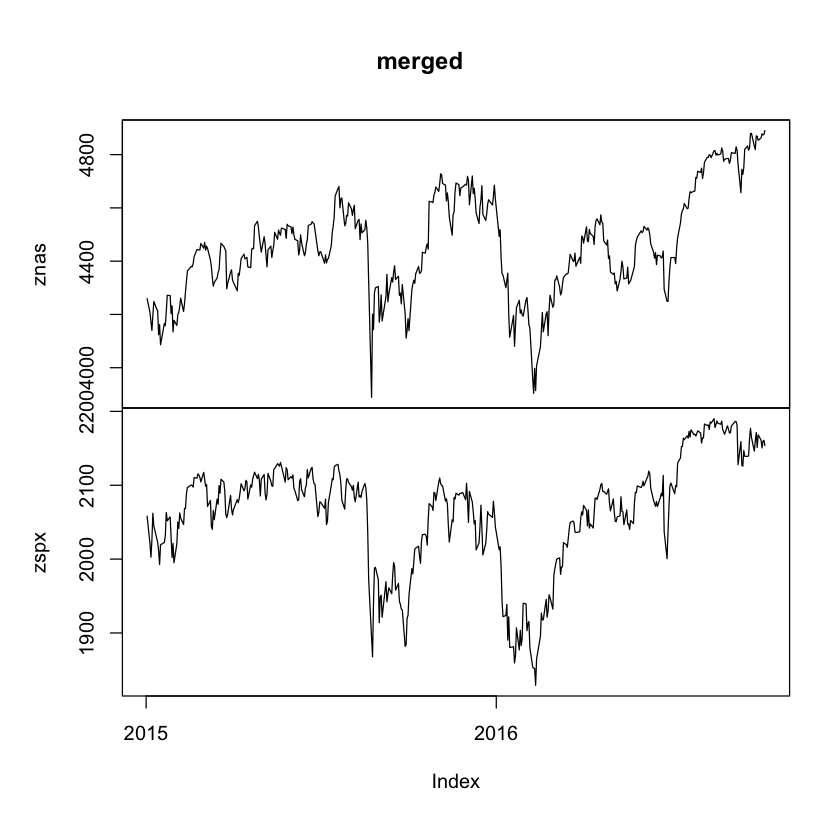

In [4]:
merged = merge(znas, zspx)
plot(merged)

### There is a high correlation between SPX and NAS

In [5]:
cor(na.locf(merged$znas),na.locf(merged$zspx))

[1] 0.8051297

### But it is not exactly 1. So a statistical arbitrage opportunity may be found

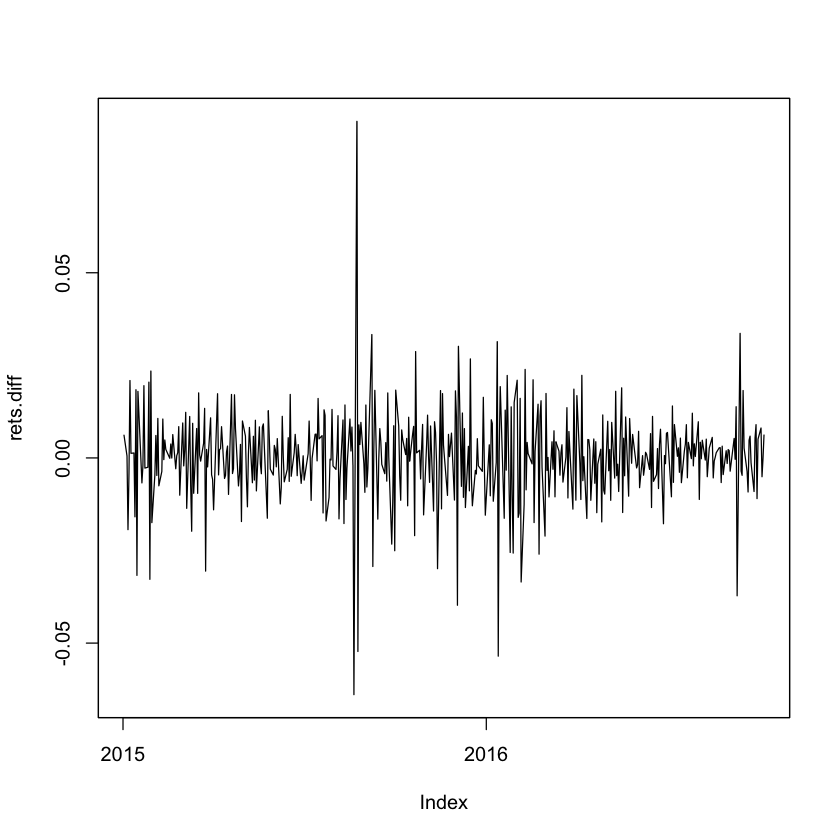

In [6]:
# find the returns

znas.rets = log(lag(znas)) - log(znas)
zspx.rets = log(lag(zspx)) - log(zspx)

rets.diff = znas.rets - zspx.rets
plot(rets.diff)

### Filter out the differences more than 0.02

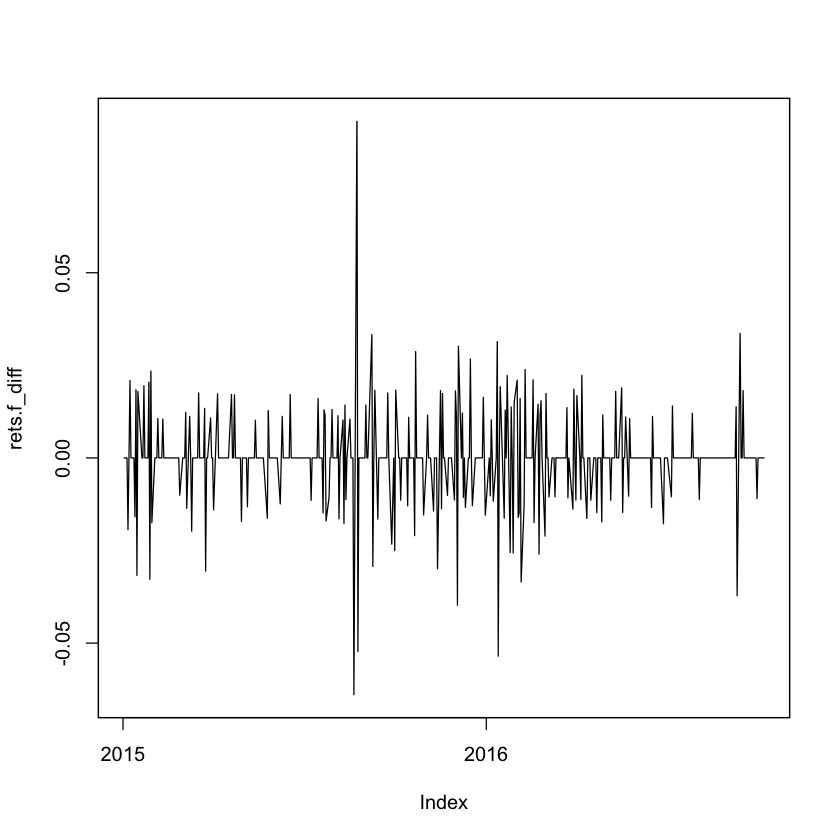

In [7]:
rets.f_diff = rets.diff*0 #filtered rets diff
#na.fill(rets.diff, fill=0)

for (i in 1:length(rets.diff)) {
    #print(abs(as.numeric(rets.diff[i])))
    if (abs(as.numeric(rets.diff[i])) > 0.015) {
        rets.f_diff[i] = rets.diff[i]
    }
}

plot(rets.f_diff)

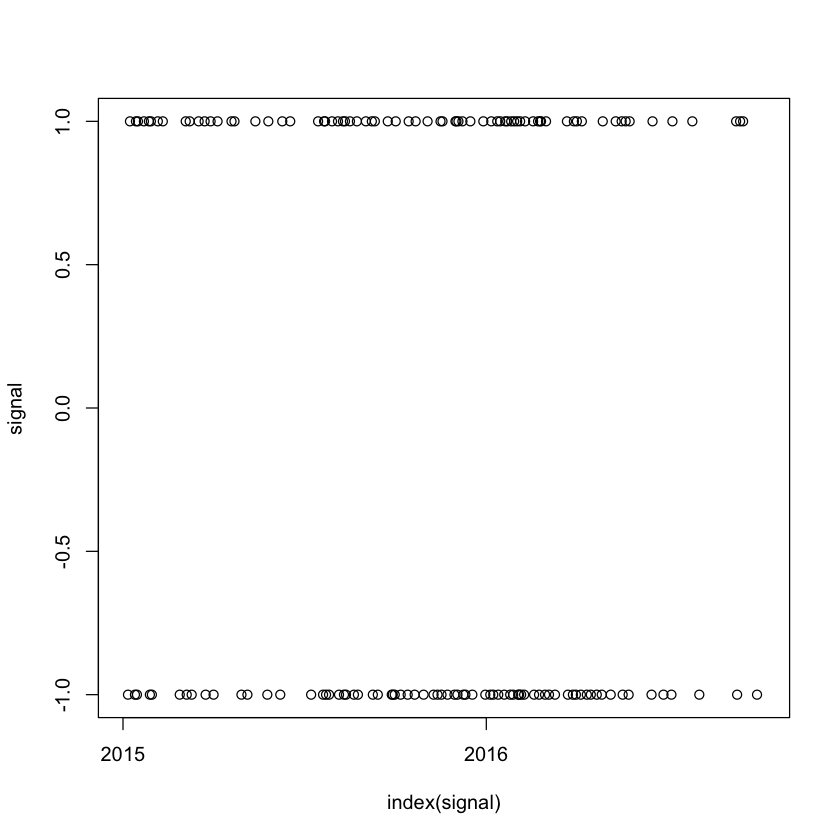

In [8]:
signal = sign(rets.f_diff)
signal[signal == 0] = NA
plot(index(signal),signal)

## When Signal == 1 Sell Spx, Buy Nas
## When Signal == -1 Buy Spx, Sell Nas

In [9]:
## test the strategy with blotter
library(blotter)

currency("USD")
stock("NAS", currency="USD", multiplier=1)
stock("SPX", currency="USD", multiplier=1)
Sys.setenv(TZ="UTC")

NAS<-xts(znas[,1] , order.by=index(znas[,1]))
SPX<-xts(zspx[,1] , order.by=index(zspx[,1]))

my.strategy <- "Arbitrage"
initPortf(my.strategy, symbols=list('NAS','SPX'), initDate="2015-01-01")
initAcct(my.strategy, portfolios=my.strategy, initDate="2015-01-01", initEq=1000000)

[1] "USD"

[1] "NAS"

[1] "SPX"

[1] "Arbitrage"

[1] "Arbitrage"

In [10]:
NAS<-xts(znas[,1] , order.by=index(znas[,1]))
SPX<-xts(zspx[,1] , order.by=index(zspx[,1]))
colnames(NAS) <- 'Price'
colnames(SPX) <- 'Price'

#NAS<-xts(NAS[,1], as.POSIXct(time(NAS))) ?
#SPX<-xts(SPX[,1], as.POSIXct(time(SPX))) ?

for (i in 1:length(signal)) {
    if(!is.na(signal[i])) {
        current_date = index(signal[i])
        qty = 100
        nas_price = as.numeric(znas[index(signal[i])])
        spx_price = as.numeric(zspx[index(signal[i])])
        if (as.numeric(signal[i]) == 1) {
            # Sell nas, buy spx
            addTxn(my.strategy, Symbol="NAS", TxnDate=current_date, TxnPrice=nas_price, TxnQty = qty, TxnFees=0)
            addTxn(my.strategy, Symbol="SPX", TxnDate=current_date, TxnPrice=spx_price, TxnQty = -qty, TxnFees=0)
        } else if (as.numeric(signal[i]) == -1) {
            #sell nass, buy spx
            addTxn(my.strategy, Symbol="NAS", TxnDate=current_date, TxnPrice=nas_price, TxnQty = -qty, TxnFees=0)
            addTxn(my.strategy, Symbol="SPX", TxnDate=current_date, TxnPrice=spx_price, TxnQty = qty, TxnFees=0)
        }
        
        updatePortf(my.strategy, Dates=current_date)
        updateAcct(my.strategy, Dates=current_date)
        updateEndEq(my.strategy, current_date)

    }
}

[1] "2015-01-06 00:00:00 NAS -100 @ 4172.16"
[1] "2015-01-06 00:00:00 SPX 100 @ 2002.609985"


Warning message in updatePortf(my.strategy, Dates = current_date):
“Incompatible methods ("Ops.POSIXt", "Ops.Date") for ">="”

[1] "2015-01-08 00:00:00 NAS 100 @ 4196.26"
[1] "2015-01-08 00:00:00 SPX -100 @ 2062.139893"


Warning message in updatePortf(my.strategy, Dates = current_date):
“Incompatible methods ("Ops.POSIXt", "Ops.Date") for ">="”

[1] "2015-01-13 00:00:00 NAS -100 @ 4214.49"
[1] "2015-01-13 00:00:00 SPX 100 @ 2023.030029"


Warning message in updatePortf(my.strategy, Dates = current_date):
“Incompatible methods ("Ops.POSIXt", "Ops.Date") for ">="”

[1] "2015-01-14 00:00:00 NAS 100 @ 4123.89"
[1] "2015-01-14 00:00:00 SPX -100 @ 2011.27002"


Warning message in updatePortf(my.strategy, Dates = current_date):
“Incompatible methods ("Ops.POSIXt", "Ops.Date") for ">="”

[1] "2015-01-15 00:00:00 NAS -100 @ 4161.69"
[1] "2015-01-15 00:00:00 SPX 100 @ 1992.670044"


Warning message in updatePortf(my.strategy, Dates = current_date):
“Incompatible methods ("Ops.POSIXt", "Ops.Date") for ">="”

[1] "2015-01-16 00:00:00 NAS 100 @ 4085.9"
[1] "2015-01-16 00:00:00 SPX -100 @ 2019.420044"


Warning message in updatePortf(my.strategy, Dates = current_date):
“Incompatible methods ("Ops.POSIXt", "Ops.Date") for ">="”

[1] "2015-01-22 00:00:00 NAS 100 @ 4212.3"
[1] "2015-01-22 00:00:00 SPX -100 @ 2063.149902"


Warning message in updatePortf(my.strategy, Dates = current_date):
“Incompatible methods ("Ops.POSIXt", "Ops.Date") for ">="”

[1] "2015-01-27 00:00:00 NAS 100 @ 4203.18"
[1] "2015-01-27 00:00:00 SPX -100 @ 2029.550049"


Warning message in updatePortf(my.strategy, Dates = current_date):
“Incompatible methods ("Ops.POSIXt", "Ops.Date") for ">="”

[1] "2015-01-28 00:00:00 NAS -100 @ 4232.19"
[1] "2015-01-28 00:00:00 SPX 100 @ 2002.160034"


Warning message in updatePortf(my.strategy, Dates = current_date):
“Incompatible methods ("Ops.POSIXt", "Ops.Date") for ">="”

[1] "2015-01-29 00:00:00 NAS 100 @ 4134.77"
[1] "2015-01-29 00:00:00 SPX -100 @ 2021.25"


Warning message in updatePortf(my.strategy, Dates = current_date):
“Incompatible methods ("Ops.POSIXt", "Ops.Date") for ">="”

[1] "2015-01-30 00:00:00 NAS -100 @ 4177.93"
[1] "2015-01-30 00:00:00 SPX 100 @ 1994.98999"


Warning message in updatePortf(my.strategy, Dates = current_date):
“Incompatible methods ("Ops.POSIXt", "Ops.Date") for ">="”

[1] "2015-02-05 00:00:00 NAS 100 @ 4230.39"
[1] "2015-02-05 00:00:00 SPX -100 @ 2062.52002"


Warning message in updatePortf(my.strategy, Dates = current_date):
“Incompatible methods ("Ops.POSIXt", "Ops.Date") for ">="”

[1] "2015-02-10 00:00:00 NAS 100 @ 4240.57"
[1] "2015-02-10 00:00:00 SPX -100 @ 2068.590088"


Warning message in updatePortf(my.strategy, Dates = current_date):
“Incompatible methods ("Ops.POSIXt", "Ops.Date") for ">="”

[1] "2015-02-27 00:00:00 NAS -100 @ 4466.45"
[1] "2015-02-27 00:00:00 SPX 100 @ 2104.5"


Warning message in updatePortf(my.strategy, Dates = current_date):
“Incompatible methods ("Ops.POSIXt", "Ops.Date") for ">="”

[1] "2015-03-05 00:00:00 NAS 100 @ 4456.08"
[1] "2015-03-05 00:00:00 SPX -100 @ 2101.040039"


Warning message in updatePortf(my.strategy, Dates = current_date):
“Incompatible methods ("Ops.POSIXt", "Ops.Date") for ">="”

[1] "2015-03-06 00:00:00 NAS -100 @ 4447.34"
[1] "2015-03-06 00:00:00 SPX 100 @ 2071.26001"


Warning message in updatePortf(my.strategy, Dates = current_date):
“Incompatible methods ("Ops.POSIXt", "Ops.Date") for ">="”

[1] "2015-03-09 00:00:00 NAS 100 @ 4404.52"
[1] "2015-03-09 00:00:00 SPX -100 @ 2079.429932"


Warning message in updatePortf(my.strategy, Dates = current_date):
“Incompatible methods ("Ops.POSIXt", "Ops.Date") for ">="”

[1] "2015-03-11 00:00:00 NAS -100 @ 4337.37"
[1] "2015-03-11 00:00:00 SPX 100 @ 2040.23999"


Warning message in updatePortf(my.strategy, Dates = current_date):
“Incompatible methods ("Ops.POSIXt", "Ops.Date") for ">="”

[1] "2015-03-18 00:00:00 NAS 100 @ 4367.89"
[1] "2015-03-18 00:00:00 SPX -100 @ 2099.5"


Warning message in updatePortf(my.strategy, Dates = current_date):
“Incompatible methods ("Ops.POSIXt", "Ops.Date") for ">="”

[1] "2015-03-24 00:00:00 NAS 100 @ 4445.84"
[1] "2015-03-24 00:00:00 SPX -100 @ 2091.5"


Warning message in updatePortf(my.strategy, Dates = current_date):
“Incompatible methods ("Ops.POSIXt", "Ops.Date") for ">="”

[1] "2015-03-25 00:00:00 NAS -100 @ 4440.14"
[1] "2015-03-25 00:00:00 SPX 100 @ 2061.050049"


Warning message in updatePortf(my.strategy, Dates = current_date):
“Incompatible methods ("Ops.POSIXt", "Ops.Date") for ">="”

[1] "2015-03-30 00:00:00 NAS 100 @ 4358.57"
[1] "2015-03-30 00:00:00 SPX -100 @ 2086.23999"


Warning message in updatePortf(my.strategy, Dates = current_date):
“Incompatible methods ("Ops.POSIXt", "Ops.Date") for ">="”

[1] "2015-04-02 00:00:00 NAS -100 @ 4320.51"
[1] "2015-04-02 00:00:00 SPX 100 @ 2066.959961"


Warning message in updatePortf(my.strategy, Dates = current_date):
“Incompatible methods ("Ops.POSIXt", "Ops.Date") for ">="”

[1] "2015-04-06 00:00:00 NAS 100 @ 4288.54"
[1] "2015-04-06 00:00:00 SPX -100 @ 2080.620117"


Warning message in updatePortf(my.strategy, Dates = current_date):
“Incompatible methods ("Ops.POSIXt", "Ops.Date") for ">="”

[1] "2015-04-20 00:00:00 NAS 100 @ 4375.68"
[1] "2015-04-20 00:00:00 SPX -100 @ 2100.399902"


Warning message in updatePortf(my.strategy, Dates = current_date):
“Incompatible methods ("Ops.POSIXt", "Ops.Date") for ">="”

[1] "2015-04-23 00:00:00 NAS 100 @ 4446.28"
[1] "2015-04-23 00:00:00 SPX -100 @ 2112.929932"


Warning message in updatePortf(my.strategy, Dates = current_date):
“Incompatible methods ("Ops.POSIXt", "Ops.Date") for ">="”

[1] "2015-04-30 00:00:00 NAS -100 @ 4462.12"
[1] "2015-04-30 00:00:00 SPX 100 @ 2085.51001"


Warning message in updatePortf(my.strategy, Dates = current_date):
“Incompatible methods ("Ops.POSIXt", "Ops.Date") for ">="”

[1] "2015-05-06 00:00:00 NAS -100 @ 4420.18"
[1] "2015-05-06 00:00:00 SPX 100 @ 2080.149902"


Warning message in updatePortf(my.strategy, Dates = current_date):
“Incompatible methods ("Ops.POSIXt", "Ops.Date") for ">="”

[1] "2015-05-14 00:00:00 NAS 100 @ 4459.34"
[1] "2015-05-14 00:00:00 SPX -100 @ 2121.100098"


Warning message in updatePortf(my.strategy, Dates = current_date):
“Incompatible methods ("Ops.POSIXt", "Ops.Date") for ">="”

[1] "2015-05-26 00:00:00 NAS -100 @ 4519.16"
[1] "2015-05-26 00:00:00 SPX 100 @ 2104.199951"


Warning message in updatePortf(my.strategy, Dates = current_date):
“Incompatible methods ("Ops.POSIXt", "Ops.Date") for ">="”

[1] "2015-05-27 00:00:00 NAS 100 @ 4486.93"
[1] "2015-05-27 00:00:00 SPX -100 @ 2123.47998"


Warning message in updatePortf(my.strategy, Dates = current_date):
“Incompatible methods ("Ops.POSIXt", "Ops.Date") for ">="”

[1] "2015-06-08 00:00:00 NAS -100 @ 4476.5"
[1] "2015-06-08 00:00:00 SPX 100 @ 2079.280029"


Warning message in updatePortf(my.strategy, Dates = current_date):
“Incompatible methods ("Ops.POSIXt", "Ops.Date") for ">="”

[1] "2015-06-10 00:00:00 NAS 100 @ 4440.88"
[1] "2015-06-10 00:00:00 SPX -100 @ 2105.199951"


Warning message in updatePortf(my.strategy, Dates = current_date):
“Incompatible methods ("Ops.POSIXt", "Ops.Date") for ">="”

[1] "2015-06-18 00:00:00 NAS 100 @ 4480.5"
[1] "2015-06-18 00:00:00 SPX -100 @ 2121.23999"


Warning message in updatePortf(my.strategy, Dates = current_date):
“Incompatible methods ("Ops.POSIXt", "Ops.Date") for ">="”

[1] "2015-07-09 00:00:00 NAS -100 @ 4406.56"
[1] "2015-07-09 00:00:00 SPX 100 @ 2051.310059"


Warning message in updatePortf(my.strategy, Dates = current_date):
“Incompatible methods ("Ops.POSIXt", "Ops.Date") for ">="”

[1] "2015-07-16 00:00:00 NAS 100 @ 4565.5"
[1] "2015-07-16 00:00:00 SPX -100 @ 2124.290039"


Warning message in updatePortf(my.strategy, Dates = current_date):
“Incompatible methods ("Ops.POSIXt", "Ops.Date") for ">="”

[1] "2015-07-21 00:00:00 NAS -100 @ 4680.26"
[1] "2015-07-21 00:00:00 SPX 100 @ 2119.209961"


Warning message in updatePortf(my.strategy, Dates = current_date):
“Incompatible methods ("Ops.POSIXt", "Ops.Date") for ">="”

[1] "2015-07-22 00:00:00 NAS 100 @ 4600.24"
[1] "2015-07-22 00:00:00 SPX -100 @ 2114.149902"


Warning message in updatePortf(my.strategy, Dates = current_date):
“Incompatible methods ("Ops.POSIXt", "Ops.Date") for ">="”

[1] "2015-07-23 00:00:00 NAS 100 @ 4633.93"
[1] "2015-07-23 00:00:00 SPX -100 @ 2102.149902"


Warning message in updatePortf(my.strategy, Dates = current_date):
“Incompatible methods ("Ops.POSIXt", "Ops.Date") for ">="”

[1] "2015-07-24 00:00:00 NAS -100 @ 4637.38"
[1] "2015-07-24 00:00:00 SPX 100 @ 2079.649902"


Warning message in updatePortf(my.strategy, Dates = current_date):
“Incompatible methods ("Ops.POSIXt", "Ops.Date") for ">="”

[1] "2015-07-27 00:00:00 NAS -100 @ 4532.78"
[1] "2015-07-27 00:00:00 SPX 100 @ 2067.639893"


Warning message in updatePortf(my.strategy, Dates = current_date):
“Incompatible methods ("Ops.POSIXt", "Ops.Date") for ">="”

[1] "2015-07-30 00:00:00 NAS 100 @ 4569.45"
[1] "2015-07-30 00:00:00 SPX -100 @ 2108.629883"


Warning message in updatePortf(my.strategy, Dates = current_date):
“Incompatible methods ("Ops.POSIXt", "Ops.Date") for ">="”

[1] "2015-08-05 00:00:00 NAS 100 @ 4593.36"
[1] "2015-08-05 00:00:00 SPX -100 @ 2099.840088"


Warning message in updatePortf(my.strategy, Dates = current_date):
“Incompatible methods ("Ops.POSIXt", "Ops.Date") for ">="”

[1] "2015-08-06 00:00:00 NAS -100 @ 4610.03"
[1] "2015-08-06 00:00:00 SPX 100 @ 2083.560059"


Warning message in updatePortf(my.strategy, Dates = current_date):
“Incompatible methods ("Ops.POSIXt", "Ops.Date") for ">="”

[1] "2015-08-10 00:00:00 NAS 100 @ 4553.68"
[1] "2015-08-10 00:00:00 SPX -100 @ 2104.179932"


Warning message in updatePortf(my.strategy, Dates = current_date):
“Incompatible methods ("Ops.POSIXt", "Ops.Date") for ">="”

[1] "2015-08-11 00:00:00 NAS -100 @ 4556.62"
[1] "2015-08-11 00:00:00 SPX 100 @ 2084.070068"


Warning message in updatePortf(my.strategy, Dates = current_date):
“Incompatible methods ("Ops.POSIXt", "Ops.Date") for ">="”

[1] "2015-08-12 00:00:00 NAS 100 @ 4480.85"
[1] "2015-08-12 00:00:00 SPX -100 @ 2086.050049"


Warning message in updatePortf(my.strategy, Dates = current_date):
“Incompatible methods ("Ops.POSIXt", "Ops.Date") for ">="”

[1] "2015-08-13 00:00:00 NAS -100 @ 4539.57"
[1] "2015-08-13 00:00:00 SPX 100 @ 2083.389893"


Warning message in updatePortf(my.strategy, Dates = current_date):
“Incompatible methods ("Ops.POSIXt", "Ops.Date") for ">="”

[1] "2015-08-17 00:00:00 NAS 100 @ 4517.89"
[1] "2015-08-17 00:00:00 SPX -100 @ 2102.439941"


Warning message in updatePortf(my.strategy, Dates = current_date):
“Incompatible methods ("Ops.POSIXt", "Ops.Date") for ">="”

[1] "2015-08-21 00:00:00 NAS -100 @ 4315.56"
[1] "2015-08-21 00:00:00 SPX 100 @ 1970.890015"


Warning message in updatePortf(my.strategy, Dates = current_date):
“Incompatible methods ("Ops.POSIXt", "Ops.Date") for ">="”

[1] "2015-08-24 00:00:00 NAS 100 @ 3888.77"
[1] "2015-08-24 00:00:00 SPX -100 @ 1893.209961"


Warning message in updatePortf(my.strategy, Dates = current_date):
“Incompatible methods ("Ops.POSIXt", "Ops.Date") for ">="”

[1] "2015-08-25 00:00:00 NAS -100 @ 4201.18"
[1] "2015-08-25 00:00:00 SPX 100 @ 1867.609985"


Warning message in updatePortf(my.strategy, Dates = current_date):
“Incompatible methods ("Ops.POSIXt", "Ops.Date") for ">="”

[1] "2015-09-02 00:00:00 NAS 100 @ 4208.07"
[1] "2015-09-02 00:00:00 SPX -100 @ 1948.859985"


Warning message in updatePortf(my.strategy, Dates = current_date):
“Incompatible methods ("Ops.POSIXt", "Ops.Date") for ">="”

[1] "2015-09-08 00:00:00 NAS 100 @ 4267.29"
[1] "2015-09-08 00:00:00 SPX -100 @ 1969.410034"


Warning message in updatePortf(my.strategy, Dates = current_date):
“Incompatible methods ("Ops.POSIXt", "Ops.Date") for ">="”

[1] "2015-09-09 00:00:00 NAS -100 @ 4350.55"
[1] "2015-09-09 00:00:00 SPX 100 @ 1942.040039"


Warning message in updatePortf(my.strategy, Dates = current_date):
“Incompatible methods ("Ops.POSIXt", "Ops.Date") for ">="”

[1] "2015-09-11 00:00:00 NAS 100 @ 4277.07"
[1] "2015-09-11 00:00:00 SPX -100 @ 1961.050049"


Warning message in updatePortf(my.strategy, Dates = current_date):
“Incompatible methods ("Ops.POSIXt", "Ops.Date") for ">="”

[1] "2015-09-14 00:00:00 NAS -100 @ 4338.04"
[1] "2015-09-14 00:00:00 SPX 100 @ 1953.030029"


Warning message in updatePortf(my.strategy, Dates = current_date):
“Incompatible methods ("Ops.POSIXt", "Ops.Date") for ">="”

[1] "2015-09-24 00:00:00 NAS 100 @ 4239.52"
[1] "2015-09-24 00:00:00 SPX -100 @ 1932.23999"


Warning message in updatePortf(my.strategy, Dates = current_date):
“Incompatible methods ("Ops.POSIXt", "Ops.Date") for ">="”

[1] "2015-09-28 00:00:00 NAS -100 @ 4202.69"
[1] "2015-09-28 00:00:00 SPX 100 @ 1881.77002"


Warning message in updatePortf(my.strategy, Dates = current_date):
“Incompatible methods ("Ops.POSIXt", "Ops.Date") for ">="”

[1] "2015-09-29 00:00:00 NAS -100 @ 4111.07"
[1] "2015-09-29 00:00:00 SPX 100 @ 1884.089966"


Warning message in updatePortf(my.strategy, Dates = current_date):
“Incompatible methods ("Ops.POSIXt", "Ops.Date") for ">="”

[1] "2015-10-01 00:00:00 NAS -100 @ 4184.48"
[1] "2015-10-01 00:00:00 SPX 100 @ 1923.819946"


Warning message in updatePortf(my.strategy, Dates = current_date):
“Incompatible methods ("Ops.POSIXt", "Ops.Date") for ">="”

[1] "2015-10-02 00:00:00 NAS 100 @ 4139.34"
[1] "2015-10-02 00:00:00 SPX -100 @ 1951.359985"


Warning message in updatePortf(my.strategy, Dates = current_date):
“Incompatible methods ("Ops.POSIXt", "Ops.Date") for ">="”

[1] "2015-10-07 00:00:00 NAS -100 @ 4328.21"
[1] "2015-10-07 00:00:00 SPX 100 @ 1995.829956"


Warning message in updatePortf(my.strategy, Dates = current_date):
“Incompatible methods ("Ops.POSIXt", "Ops.Date") for ">="”

[1] "2015-10-14 00:00:00 NAS -100 @ 4356.55"
[1] "2015-10-14 00:00:00 SPX 100 @ 1994.23999"


Warning message in updatePortf(my.strategy, Dates = current_date):
“Incompatible methods ("Ops.POSIXt", "Ops.Date") for ">="”

[1] "2015-10-15 00:00:00 NAS 100 @ 4364.46"
[1] "2015-10-15 00:00:00 SPX -100 @ 2023.859985"


Warning message in updatePortf(my.strategy, Dates = current_date):
“Incompatible methods ("Ops.POSIXt", "Ops.Date") for ">="”

[1] "2015-10-21 00:00:00 NAS -100 @ 4464.82"
[1] "2015-10-21 00:00:00 SPX 100 @ 2018.939941"


Warning message in updatePortf(my.strategy, Dates = current_date):
“Incompatible methods ("Ops.POSIXt", "Ops.Date") for ">="”

[1] "2015-10-22 00:00:00 NAS 100 @ 4444.79"
[1] "2015-10-22 00:00:00 SPX -100 @ 2052.51001"


Warning message in updatePortf(my.strategy, Dates = current_date):
“Incompatible methods ("Ops.POSIXt", "Ops.Date") for ">="”

[1] "2015-10-30 00:00:00 NAS -100 @ 4678.38"
[1] "2015-10-30 00:00:00 SPX 100 @ 2079.360107"


Warning message in updatePortf(my.strategy, Dates = current_date):
“Incompatible methods ("Ops.POSIXt", "Ops.Date") for ">="”

[1] "2015-11-03 00:00:00 NAS 100 @ 4690.33"
[1] "2015-11-03 00:00:00 SPX -100 @ 2109.790039"


Warning message in updatePortf(my.strategy, Dates = current_date):
“Incompatible methods ("Ops.POSIXt", "Ops.Date") for ">="”

[1] "2015-11-09 00:00:00 NAS -100 @ 4685.67"
[1] "2015-11-09 00:00:00 SPX 100 @ 2078.580078"


Warning message in updatePortf(my.strategy, Dates = current_date):
“Incompatible methods ("Ops.POSIXt", "Ops.Date") for ">="”

[1] "2015-11-13 00:00:00 NAS -100 @ 4566"
[1] "2015-11-13 00:00:00 SPX 100 @ 2023.040039"


Warning message in updatePortf(my.strategy, Dates = current_date):
“Incompatible methods ("Ops.POSIXt", "Ops.Date") for ">="”

[1] "2015-11-16 00:00:00 NAS 100 @ 4497.53"
[1] "2015-11-16 00:00:00 SPX -100 @ 2053.189941"


Warning message in updatePortf(my.strategy, Dates = current_date):
“Incompatible methods ("Ops.POSIXt", "Ops.Date") for ">="”

[1] "2015-11-17 00:00:00 NAS -100 @ 4573.95"
[1] "2015-11-17 00:00:00 SPX 100 @ 2050.439941"


Warning message in updatePortf(my.strategy, Dates = current_date):
“Incompatible methods ("Ops.POSIXt", "Ops.Date") for ">="”

[1] "2015-11-18 00:00:00 NAS 100 @ 4584.38"
[1] "2015-11-18 00:00:00 SPX -100 @ 2083.580078"


Warning message in updatePortf(my.strategy, Dates = current_date):
“Incompatible methods ("Ops.POSIXt", "Ops.Date") for ">="”

[1] "2015-11-23 00:00:00 NAS -100 @ 4687.19"
[1] "2015-11-23 00:00:00 SPX 100 @ 2086.590088"


Warning message in updatePortf(my.strategy, Dates = current_date):
“Incompatible methods ("Ops.POSIXt", "Ops.Date") for ">="”

[1] "2015-11-30 00:00:00 NAS -100 @ 4688.73"
[1] "2015-11-30 00:00:00 SPX 100 @ 2080.409912"


Warning message in updatePortf(my.strategy, Dates = current_date):
“Incompatible methods ("Ops.POSIXt", "Ops.Date") for ">="”

[1] "2015-12-01 00:00:00 NAS 100 @ 4685.22"
[1] "2015-12-01 00:00:00 SPX -100 @ 2102.629883"


Warning message in updatePortf(my.strategy, Dates = current_date):
“Incompatible methods ("Ops.POSIXt", "Ops.Date") for ">="”

[1] "2015-12-02 00:00:00 NAS 100 @ 4718.35"
[1] "2015-12-02 00:00:00 SPX -100 @ 2079.51001"


Warning message in updatePortf(my.strategy, Dates = current_date):
“Incompatible methods ("Ops.POSIXt", "Ops.Date") for ">="”

[1] "2015-12-03 00:00:00 NAS -100 @ 4702.52"
[1] "2015-12-03 00:00:00 SPX 100 @ 2049.620117"


Warning message in updatePortf(my.strategy, Dates = current_date):
“Incompatible methods ("Ops.POSIXt", "Ops.Date") for ">="”

[1] "2015-12-04 00:00:00 NAS 100 @ 4611.89"
[1] "2015-12-04 00:00:00 SPX -100 @ 2091.689941"


Warning message in updatePortf(my.strategy, Dates = current_date):
“Incompatible methods ("Ops.POSIXt", "Ops.Date") for ">="”

[1] "2015-12-08 00:00:00 NAS 100 @ 4653.3"
[1] "2015-12-08 00:00:00 SPX -100 @ 2063.590088"


Warning message in updatePortf(my.strategy, Dates = current_date):
“Incompatible methods ("Ops.POSIXt", "Ops.Date") for ">="”

[1] "2015-12-09 00:00:00 NAS -100 @ 4673.62"
[1] "2015-12-09 00:00:00 SPX 100 @ 2047.619995"


Warning message in updatePortf(my.strategy, Dates = current_date):
“Incompatible methods ("Ops.POSIXt", "Ops.Date") for ">="”

[1] "2015-12-11 00:00:00 NAS -100 @ 4580.65"
[1] "2015-12-11 00:00:00 SPX 100 @ 2012.369995"


Warning message in updatePortf(my.strategy, Dates = current_date):
“Incompatible methods ("Ops.POSIXt", "Ops.Date") for ">="”

[1] "2015-12-16 00:00:00 NAS 100 @ 4629.35"
[1] "2015-12-16 00:00:00 SPX -100 @ 2073.070068"


Warning message in updatePortf(my.strategy, Dates = current_date):
“Incompatible methods ("Ops.POSIXt", "Ops.Date") for ">="”

[1] "2015-12-18 00:00:00 NAS -100 @ 4576.08"
[1] "2015-12-18 00:00:00 SPX 100 @ 2005.550049"


Warning message in updatePortf(my.strategy, Dates = current_date):
“Incompatible methods ("Ops.POSIXt", "Ops.Date") for ">="”

[1] "2015-12-29 00:00:00 NAS 100 @ 4642.85"
[1] "2015-12-29 00:00:00 SPX -100 @ 2078.360107"


Warning message in updatePortf(my.strategy, Dates = current_date):
“Incompatible methods ("Ops.POSIXt", "Ops.Date") for ">="”

[1] "2015-12-31 00:00:00 NAS -100 @ 4634.42"
[1] "2015-12-31 00:00:00 SPX 100 @ 2043.939941"


Warning message in updatePortf(my.strategy, Dates = current_date):
“Incompatible methods ("Ops.POSIXt", "Ops.Date") for ">="”

[1] "2016-01-05 00:00:00 NAS -100 @ 4518.48"
[1] "2016-01-05 00:00:00 SPX 100 @ 2016.709961"


Warning message in updatePortf(my.strategy, Dates = current_date):
“Incompatible methods ("Ops.POSIXt", "Ops.Date") for ">="”

[1] "2016-01-06 00:00:00 NAS 100 @ 4413.86"
[1] "2016-01-06 00:00:00 SPX -100 @ 1990.26001"


Warning message in updatePortf(my.strategy, Dates = current_date):
“Incompatible methods ("Ops.POSIXt", "Ops.Date") for ">="”

[1] "2016-01-08 00:00:00 NAS -100 @ 4347.12"
[1] "2016-01-08 00:00:00 SPX 100 @ 1922.030029"


Warning message in updatePortf(my.strategy, Dates = current_date):
“Incompatible methods ("Ops.POSIXt", "Ops.Date") for ">="”

[1] "2016-01-12 00:00:00 NAS 100 @ 4328.53"
[1] "2016-01-12 00:00:00 SPX -100 @ 1938.680054"


Warning message in updatePortf(my.strategy, Dates = current_date):
“Incompatible methods ("Ops.POSIXt", "Ops.Date") for ">="”

[1] "2016-01-13 00:00:00 NAS -100 @ 4355.09"
[1] "2016-01-13 00:00:00 SPX 100 @ 1890.280029"


Warning message in updatePortf(my.strategy, Dates = current_date):
“Incompatible methods ("Ops.POSIXt", "Ops.Date") for ">="”

[1] "2016-01-15 00:00:00 NAS 100 @ 4114.47"
[1] "2016-01-15 00:00:00 SPX -100 @ 1880.329956"


Warning message in updatePortf(my.strategy, Dates = current_date):
“Incompatible methods ("Ops.POSIXt", "Ops.Date") for ">="”

[1] "2016-01-19 00:00:00 NAS -100 @ 4196.68"
[1] "2016-01-19 00:00:00 SPX 100 @ 1881.329956"


Warning message in updatePortf(my.strategy, Dates = current_date):
“Incompatible methods ("Ops.POSIXt", "Ops.Date") for ">="”

[1] "2016-01-20 00:00:00 NAS 100 @ 4080.57"
[1] "2016-01-20 00:00:00 SPX -100 @ 1859.329956"


Warning message in updatePortf(my.strategy, Dates = current_date):
“Incompatible methods ("Ops.POSIXt", "Ops.Date") for ">="”

[1] "2016-01-22 00:00:00 NAS 100 @ 4225.39"
[1] "2016-01-22 00:00:00 SPX -100 @ 1906.900024"


Warning message in updatePortf(my.strategy, Dates = current_date):
“Incompatible methods ("Ops.POSIXt", "Ops.Date") for ">="”

[1] "2016-01-25 00:00:00 NAS -100 @ 4252.99"
[1] "2016-01-25 00:00:00 SPX 100 @ 1877.079956"


Warning message in updatePortf(my.strategy, Dates = current_date):
“Incompatible methods ("Ops.POSIXt", "Ops.Date") for ">="”

[1] "2016-01-26 00:00:00 NAS 100 @ 4204.44"
[1] "2016-01-26 00:00:00 SPX -100 @ 1903.630005"


Warning message in updatePortf(my.strategy, Dates = current_date):
“Incompatible methods ("Ops.POSIXt", "Ops.Date") for ">="”

[1] "2016-01-28 00:00:00 NAS -100 @ 4198.53"
[1] "2016-01-28 00:00:00 SPX 100 @ 1893.359985"


Warning message in updatePortf(my.strategy, Dates = current_date):
“Incompatible methods ("Ops.POSIXt", "Ops.Date") for ">="”

[1] "2016-01-29 00:00:00 NAS 100 @ 4193.35"
[1] "2016-01-29 00:00:00 SPX -100 @ 1940.23999"


Warning message in updatePortf(my.strategy, Dates = current_date):
“Incompatible methods ("Ops.POSIXt", "Ops.Date") for ">="”

[1] "2016-02-01 00:00:00 NAS 100 @ 4254.74"
[1] "2016-02-01 00:00:00 SPX -100 @ 1939.380005"


Warning message in updatePortf(my.strategy, Dates = current_date):
“Incompatible methods ("Ops.POSIXt", "Ops.Date") for ">="”

[1] "2016-02-02 00:00:00 NAS -100 @ 4263.54"
[1] "2016-02-02 00:00:00 SPX 100 @ 1903.030029"


Warning message in updatePortf(my.strategy, Dates = current_date):
“Incompatible methods ("Ops.POSIXt", "Ops.Date") for ">="”

[1] "2016-02-03 00:00:00 NAS -100 @ 4216.56"
[1] "2016-02-03 00:00:00 SPX 100 @ 1912.530029"


Warning message in updatePortf(my.strategy, Dates = current_date):
“Incompatible methods ("Ops.POSIXt", "Ops.Date") for ">="”

[1] "2016-02-04 00:00:00 NAS 100 @ 4160.47"
[1] "2016-02-04 00:00:00 SPX -100 @ 1915.449951"


Warning message in updatePortf(my.strategy, Dates = current_date):
“Incompatible methods ("Ops.POSIXt", "Ops.Date") for ">="”

[1] "2016-02-05 00:00:00 NAS -100 @ 4149.78"
[1] "2016-02-05 00:00:00 SPX 100 @ 1880.050049"


Warning message in updatePortf(my.strategy, Dates = current_date):
“Incompatible methods ("Ops.POSIXt", "Ops.Date") for ">="”

[1] "2016-02-08 00:00:00 NAS -100 @ 3956.27"
[1] "2016-02-08 00:00:00 SPX 100 @ 1853.439941"


Warning message in updatePortf(my.strategy, Dates = current_date):
“Incompatible methods ("Ops.POSIXt", "Ops.Date") for ">="”

[1] "2016-02-09 00:00:00 NAS 100 @ 3903.71"
[1] "2016-02-09 00:00:00 SPX -100 @ 1852.209961"


Warning message in updatePortf(my.strategy, Dates = current_date):
“Incompatible methods ("Ops.POSIXt", "Ops.Date") for ">="”

[1] "2016-02-17 00:00:00 NAS 100 @ 4139.02"
[1] "2016-02-17 00:00:00 SPX -100 @ 1926.819946"


Warning message in updatePortf(my.strategy, Dates = current_date):
“Incompatible methods ("Ops.POSIXt", "Ops.Date") for ">="”

[1] "2016-02-18 00:00:00 NAS -100 @ 4207.56"
[1] "2016-02-18 00:00:00 SPX 100 @ 1917.829956"


Warning message in updatePortf(my.strategy, Dates = current_date):
“Incompatible methods ("Ops.POSIXt", "Ops.Date") for ">="”

[1] "2016-02-22 00:00:00 NAS 100 @ 4201.82"
[1] "2016-02-22 00:00:00 SPX -100 @ 1945.5"


Warning message in updatePortf(my.strategy, Dates = current_date):
“Incompatible methods ("Ops.POSIXt", "Ops.Date") for ">="”

[1] "2016-02-23 00:00:00 NAS -100 @ 4210.1"
[1] "2016-02-23 00:00:00 SPX 100 @ 1921.27002"


Warning message in updatePortf(my.strategy, Dates = current_date):
“Incompatible methods ("Ops.POSIXt", "Ops.Date") for ">="”

[1] "2016-02-24 00:00:00 NAS 100 @ 4120.34"
[1] "2016-02-24 00:00:00 SPX -100 @ 1929.800049"


Warning message in updatePortf(my.strategy, Dates = current_date):
“Incompatible methods ("Ops.POSIXt", "Ops.Date") for ">="”

[1] "2016-02-25 00:00:00 NAS 100 @ 4214.77"
[1] "2016-02-25 00:00:00 SPX -100 @ 1951.699951"


Warning message in updatePortf(my.strategy, Dates = current_date):
“Incompatible methods ("Ops.POSIXt", "Ops.Date") for ">="”

[1] "2016-02-29 00:00:00 NAS -100 @ 4226.76"
[1] "2016-02-29 00:00:00 SPX 100 @ 1932.22998"


Warning message in updatePortf(my.strategy, Dates = current_date):
“Incompatible methods ("Ops.POSIXt", "Ops.Date") for ">="”

[1] "2016-03-01 00:00:00 NAS 100 @ 4237.28"
[1] "2016-03-01 00:00:00 SPX -100 @ 1978.349976"


Warning message in updatePortf(my.strategy, Dates = current_date):
“Incompatible methods ("Ops.POSIXt", "Ops.Date") for ">="”

[1] "2016-03-04 00:00:00 NAS -100 @ 4344.67"
[1] "2016-03-04 00:00:00 SPX 100 @ 1999.98999"


Warning message in updatePortf(my.strategy, Dates = current_date):
“Incompatible methods ("Ops.POSIXt", "Ops.Date") for ">="”

[1] "2016-03-10 00:00:00 NAS -100 @ 4313.81"
[1] "2016-03-10 00:00:00 SPX 100 @ 1989.569946"


Warning message in updatePortf(my.strategy, Dates = current_date):
“Incompatible methods ("Ops.POSIXt", "Ops.Date") for ">="”

[1] "2016-03-22 00:00:00 NAS 100 @ 4398.49"
[1] "2016-03-22 00:00:00 SPX -100 @ 2049.800049"


Warning message in updatePortf(my.strategy, Dates = current_date):
“Incompatible methods ("Ops.POSIXt", "Ops.Date") for ">="”

[1] "2016-03-23 00:00:00 NAS -100 @ 4430.11"
[1] "2016-03-23 00:00:00 SPX 100 @ 2036.709961"


Warning message in updatePortf(my.strategy, Dates = current_date):
“Incompatible methods ("Ops.POSIXt", "Ops.Date") for ">="”

[1] "2016-03-28 00:00:00 NAS -100 @ 4414.61"
[1] "2016-03-28 00:00:00 SPX 100 @ 2037.050049"


Warning message in updatePortf(my.strategy, Dates = current_date):
“Incompatible methods ("Ops.POSIXt", "Ops.Date") for ">="”

[1] "2016-03-29 00:00:00 NAS 100 @ 4392.41"
[1] "2016-03-29 00:00:00 SPX -100 @ 2055.01001"


Warning message in updatePortf(my.strategy, Dates = current_date):
“Incompatible methods ("Ops.POSIXt", "Ops.Date") for ">="”

[1] "2016-03-31 00:00:00 NAS -100 @ 4490.38"
[1] "2016-03-31 00:00:00 SPX 100 @ 2059.73999"


Warning message in updatePortf(my.strategy, Dates = current_date):
“Incompatible methods ("Ops.POSIXt", "Ops.Date") for ">="”

[1] "2016-04-01 00:00:00 NAS 100 @ 4467.57"
[1] "2016-04-01 00:00:00 SPX -100 @ 2072.780029"


Warning message in updatePortf(my.strategy, Dates = current_date):
“Incompatible methods ("Ops.POSIXt", "Ops.Date") for ">="”

[1] "2016-04-05 00:00:00 NAS -100 @ 4476.44"
[1] "2016-04-05 00:00:00 SPX 100 @ 2045.170044"


Warning message in updatePortf(my.strategy, Dates = current_date):
“Incompatible methods ("Ops.POSIXt", "Ops.Date") for ">="”

[1] "2016-04-06 00:00:00 NAS 100 @ 4473"
[1] "2016-04-06 00:00:00 SPX -100 @ 2066.659912"


Warning message in updatePortf(my.strategy, Dates = current_date):
“Incompatible methods ("Ops.POSIXt", "Ops.Date") for ">="”

[1] "2016-04-11 00:00:00 NAS -100 @ 4493.07"
[1] "2016-04-11 00:00:00 SPX 100 @ 2041.98999"


Warning message in updatePortf(my.strategy, Dates = current_date):
“Incompatible methods ("Ops.POSIXt", "Ops.Date") for ">="”

[1] "2016-04-15 00:00:00 NAS -100 @ 4558.99"
[1] "2016-04-15 00:00:00 SPX 100 @ 2080.72998"


Warning message in updatePortf(my.strategy, Dates = current_date):
“Incompatible methods ("Ops.POSIXt", "Ops.Date") for ">="”

[1] "2016-04-21 00:00:00 NAS -100 @ 4542.48"
[1] "2016-04-21 00:00:00 SPX 100 @ 2091.47998"


Warning message in updatePortf(my.strategy, Dates = current_date):
“Incompatible methods ("Ops.POSIXt", "Ops.Date") for ">="”

[1] "2016-04-26 00:00:00 NAS -100 @ 4479.31"
[1] "2016-04-26 00:00:00 SPX 100 @ 2091.699951"


Warning message in updatePortf(my.strategy, Dates = current_date):
“Incompatible methods ("Ops.POSIXt", "Ops.Date") for ">="”

[1] "2016-04-27 00:00:00 NAS 100 @ 4409.86"
[1] "2016-04-27 00:00:00 SPX -100 @ 2095.149902"


Warning message in updatePortf(my.strategy, Dates = current_date):
“Incompatible methods ("Ops.POSIXt", "Ops.Date") for ">="”

[1] "2016-05-05 00:00:00 NAS -100 @ 4323.78"
[1] "2016-05-05 00:00:00 SPX 100 @ 2050.629883"


Warning message in updatePortf(my.strategy, Dates = current_date):
“Incompatible methods ("Ops.POSIXt", "Ops.Date") for ">="”

[1] "2016-05-10 00:00:00 NAS 100 @ 4363"
[1] "2016-05-10 00:00:00 SPX -100 @ 2084.389893"


Warning message in updatePortf(my.strategy, Dates = current_date):
“Incompatible methods ("Ops.POSIXt", "Ops.Date") for ">="”

[1] "2016-05-16 00:00:00 NAS 100 @ 4336.46"
[1] "2016-05-16 00:00:00 SPX -100 @ 2066.659912"


Warning message in updatePortf(my.strategy, Dates = current_date):
“Incompatible methods ("Ops.POSIXt", "Ops.Date") for ">="”

[1] "2016-05-17 00:00:00 NAS -100 @ 4377.73"
[1] "2016-05-17 00:00:00 SPX 100 @ 2047.209961"


Warning message in updatePortf(my.strategy, Dates = current_date):
“Incompatible methods ("Ops.POSIXt", "Ops.Date") for ">="”

[1] "2016-05-20 00:00:00 NAS 100 @ 4326.67"
[1] "2016-05-20 00:00:00 SPX -100 @ 2052.320068"


Warning message in updatePortf(my.strategy, Dates = current_date):
“Incompatible methods ("Ops.POSIXt", "Ops.Date") for ">="”

[1] "2016-05-23 00:00:00 NAS -100 @ 4365.63"
[1] "2016-05-23 00:00:00 SPX 100 @ 2048.040039"


Warning message in updatePortf(my.strategy, Dates = current_date):
“Incompatible methods ("Ops.POSIXt", "Ops.Date") for ">="”

[1] "2016-05-24 00:00:00 NAS 100 @ 4379.9"
[1] "2016-05-24 00:00:00 SPX -100 @ 2076.060059"


Warning message in updatePortf(my.strategy, Dates = current_date):
“Incompatible methods ("Ops.POSIXt", "Ops.Date") for ">="”

[1] "2016-06-15 00:00:00 NAS -100 @ 4432.36"
[1] "2016-06-15 00:00:00 SPX 100 @ 2071.5"


Warning message in updatePortf(my.strategy, Dates = current_date):
“Incompatible methods ("Ops.POSIXt", "Ops.Date") for ">="”

[1] "2016-06-16 00:00:00 NAS 100 @ 4387.11"
[1] "2016-06-16 00:00:00 SPX -100 @ 2077.98999"


Warning message in updatePortf(my.strategy, Dates = current_date):
“Incompatible methods ("Ops.POSIXt", "Ops.Date") for ">="”

[1] "2016-06-27 00:00:00 NAS -100 @ 4249.45"
[1] "2016-06-27 00:00:00 SPX 100 @ 2000.540039"


Warning message in updatePortf(my.strategy, Dates = current_date):
“Incompatible methods ("Ops.POSIXt", "Ops.Date") for ">="”

[1] "2016-07-05 00:00:00 NAS -100 @ 4413.56"
[1] "2016-07-05 00:00:00 SPX 100 @ 2088.550049"


Warning message in updatePortf(my.strategy, Dates = current_date):
“Incompatible methods ("Ops.POSIXt", "Ops.Date") for ">="”

[1] "2016-07-06 00:00:00 NAS 100 @ 4390.87"
[1] "2016-07-06 00:00:00 SPX -100 @ 2099.72998"


Warning message in updatePortf(my.strategy, Dates = current_date):
“Incompatible methods ("Ops.POSIXt", "Ops.Date") for ">="”

[1] "2016-07-26 00:00:00 NAS 100 @ 4663.17"
[1] "2016-07-26 00:00:00 SPX -100 @ 2169.179932"


Warning message in updatePortf(my.strategy, Dates = current_date):
“Incompatible methods ("Ops.POSIXt", "Ops.Date") for ">="”

[1] "2016-08-02 00:00:00 NAS -100 @ 4749.18"
[1] "2016-08-02 00:00:00 SPX 100 @ 2157.030029"


Warning message in updatePortf(my.strategy, Dates = current_date):
“Incompatible methods ("Ops.POSIXt", "Ops.Date") for ">="”

[1] "2016-09-08 00:00:00 NAS 100 @ 4816.71"
[1] "2016-09-08 00:00:00 SPX -100 @ 2181.300049"


Warning message in updatePortf(my.strategy, Dates = current_date):
“Incompatible methods ("Ops.POSIXt", "Ops.Date") for ">="”

[1] "2016-09-09 00:00:00 NAS -100 @ 4764.01"
[1] "2016-09-09 00:00:00 SPX 100 @ 2127.810059"


Warning message in updatePortf(my.strategy, Dates = current_date):
“Incompatible methods ("Ops.POSIXt", "Ops.Date") for ">="”

[1] "2016-09-12 00:00:00 NAS 100 @ 4657.29"
[1] "2016-09-12 00:00:00 SPX -100 @ 2159.040039"


Warning message in updatePortf(my.strategy, Dates = current_date):
“Incompatible methods ("Ops.POSIXt", "Ops.Date") for ">="”

[1] "2016-09-15 00:00:00 NAS 100 @ 4751.03"
[1] "2016-09-15 00:00:00 SPX -100 @ 2147.26001"


Warning message in updatePortf(my.strategy, Dates = current_date):
“Incompatible methods ("Ops.POSIXt", "Ops.Date") for ">="”

[1] "2016-09-29 00:00:00 NAS -100 @ 4868.62"
[1] "2016-09-29 00:00:00 SPX 100 @ 2151.129883"


Warning message in updatePortf(my.strategy, Dates = current_date):
“Incompatible methods ("Ops.POSIXt", "Ops.Date") for ">="”

In [11]:
PortfReturns(Account="Arbitrage")

           NAS.DailyEndEq SPX.DailyEndEq
2015-01-05       0.000000   0.0000000000
2015-01-06       0.000000   0.0000000000
2015-01-07       0.000000   0.0000000000
2015-01-08      -0.005654   0.0036239869
2015-01-12       0.000000   0.0000000000
2015-01-13       0.000000   0.0000000000
2015-01-14      -0.403329   0.1999510011
2015-01-15       0.000000   0.0000000000
2015-01-16       0.007579   0.0026750000
2015-01-21       0.000000   0.0000000000
2015-01-22       0.000000   0.0000000000
2015-01-26       0.000000   0.0000000000
2015-01-27       0.413541  -0.2002010010
2015-01-28       0.852240  -0.3949540038
2015-01-29       0.403735  -0.2040339966
2015-01-30       0.008632   0.0052520020
2015-02-04       0.000000   0.0000000000
2015-02-05       0.002324  -0.0021010010
2015-02-09       0.000000   0.0000000000
2015-02-10       0.005876  -0.0043700196
2015-02-26       0.000000   0.0000000000
2015-02-27       0.007332   0.0018719970
2015-03-04       0.000000   0.0000000000
2015-03-05      

In [12]:
getEndEq(my.strategy, '2016-09-12')

[1] 963845.2